In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [5]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 9999:
Image - Min Value: 3 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


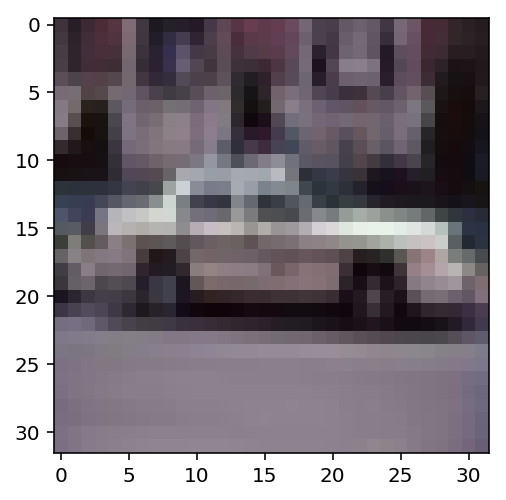

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 9999
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [7]:
features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[0]
#plt.imshow(sample_image)
imageTest = features[0:200]
imageTest.shape

(200, 32, 32, 3)

In [8]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [9]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [10]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [11]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


In [12]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## placeholder variables

In [13]:
# Remove previous weights, bias, inputs, etc..
import tensorflow as tf
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [14]:
conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

In [15]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [16]:
#logits = conv_net(x, keep_prob)
#model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training


In [17]:
conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.relu(conv1)
conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


In [18]:
conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 64) dtype=float32>

In [19]:
conv2 = tf.nn.conv2d(conv1_pool, conv2_filter, strides=[1,1,1,1], padding='SAME')
conv2 = tf.nn.relu(conv2)
conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    

In [20]:
conv2_pool

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 8, 128) dtype=float32>

In [21]:
conv3 = tf.nn.conv2d(conv2_pool, conv3_filter, strides=[1,1,1,1], padding='SAME')
conv3 = tf.nn.relu(conv3)
conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 

In [22]:
conv3_pool

<tf.Tensor 'MaxPool_2:0' shape=(?, 4, 4, 256) dtype=float32>

In [23]:
conv4 = tf.nn.conv2d(conv3_pool, conv4_filter, strides=[1,1,1,1], padding='SAME')
conv4 = tf.nn.relu(conv4)
conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [24]:
conv4_pool

<tf.Tensor 'MaxPool_3:0' shape=(?, 2, 2, 512) dtype=float32>

In [25]:
flat = tf.contrib.layers.flatten(conv4_pool) 
flat

<tf.Tensor 'Flatten/Reshape:0' shape=(?, 2048) dtype=float32>

## initializing our fully connected layers

In [26]:
fc1_filter = tf.Variable(tf.truncated_normal(shape=[2048, 128], mean=0, stddev=0.08))
fc1 = tf.matmul(flat, fc1_filter) 
full1 = tf.nn.dropout(fc1, keep_prob)

In [27]:
full1

<tf.Tensor 'dropout/mul:0' shape=(?, 128) dtype=float32>

In [28]:
fc2_filter = tf.Variable(tf.truncated_normal(shape=[128, 256], mean = 0, stddev=0.08))
fc2 = tf.matmul(full1, fc2_filter)
full2 = tf.nn.dropout(fc2, keep_prob)

In [29]:
full2

<tf.Tensor 'dropout_1/mul:0' shape=(?, 256) dtype=float32>

In [30]:
fc3_filter = tf.Variable(tf.truncated_normal(shape=[256, 512], mean = 0, stddev=0.08))
fc3 = tf.matmul(full2, fc3_filter)
full3 = tf.nn.dropout(fc3, keep_prob)

In [31]:
full3

<tf.Tensor 'dropout_2/mul:0' shape=(?, 512) dtype=float32>

In [32]:
fc4_filter = tf.Variable(tf.truncated_normal(shape=[512, 1024], mean = 0, stddev=0.08))
fc4 = tf.matmul(full3, fc4_filter)
full4 = tf.nn.dropout(fc4, keep_prob)

In [33]:
full4

<tf.Tensor 'dropout_3/mul:0' shape=(?, 1024) dtype=float32>

In [34]:
out_filter = tf.Variable(tf.truncated_normal(shape=[1024, 10], mean = 0, stddev=0.08))
out = tf.matmul(full4, out_filter)
out = tf.nn.dropout(out, keep_prob)

In [35]:
out

<tf.Tensor 'dropout_4/mul:0' shape=(?, 10) dtype=float32>

In [36]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [37]:
session.run(tf.global_variables_initializer())
train_batch_size = 64


## store the original weights

In [38]:
w_conv1_original = session.run(conv1_filter)
w_conv2_original = session.run(conv2_filter)
w_conv3_original = session.run(conv3_filter)
w_conv4_original = session.run(conv4_filter)

w_fc1_original = session.run(fc1_filter)
w_fc2_original = session.run(fc2_filter)
w_fc3_original = session.run(fc3_filter)
w_fc4_original = session.run(fc4_filter)
w_out_original = session.run(out_filter)

In [39]:
wOrigConv = [w_conv1_original,w_conv2_original, w_conv3_original, w_conv4_original]
wOrigFc = [w_fc1_original, w_fc2_original, w_fc3_original, w_fc4_original, w_out_original]

array([[[[ 0.09052077, -0.01605383, -0.1084663 , ..., -0.02752952,
          -0.13825248, -0.01142447],
         [-0.04899792, -0.03549175, -0.09668051, ...,  0.10953459,
          -0.03225554, -0.00568652],
         [-0.05312657, -0.11154146, -0.01871056, ..., -0.10876404,
          -0.12029131,  0.0661597 ]],

        [[-0.00495393, -0.1278997 , -0.0537761 , ...,  0.01641154,
          -0.07410758, -0.11132146],
         [-0.08133452,  0.00703136, -0.08567519, ..., -0.04750386,
           0.06847607,  0.02033555],
         [-0.03421512,  0.01601779,  0.08085538, ..., -0.0167829 ,
           0.12200788, -0.01896233]],

        [[-0.02440655, -0.0911535 ,  0.03041548, ...,  0.06988838,
           0.07085395, -0.02590029],
         [-0.1154736 ,  0.04780812,  0.03401347, ...,  0.04474019,
          -0.00975764, -0.06566753],
         [-0.02251646, -0.07049336, -0.00096964, ..., -0.05519389,
           0.01142974, -0.09950498]]],


       [[[ 0.07586554, -0.01034093,  0.04360655, ...,  0

## restore weights

In [48]:
def restoreWeights():
    for wIdx in range(0,len(weightsConvMat)):
            assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
            session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
            assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
            session.run(assign_op)

In [49]:
restoreWeights()

In [40]:
weightsConvMat = [conv1_filter, conv2_filter, conv3_filter, conv4_filter]
weightsFcMat = [fc1_filter, fc2_filter, fc3_filter, fc4_filter, out_filter]

wConv1 = session.run(conv1_filter)
wConv2 = session.run(conv2_filter)
wConv3 = session.run(conv3_filter)
wConv4 = session.run(conv4_filter)

wFc1 = session.run(fc1_filter)
wFc2 = session.run(fc2_filter)
wFc3 = session.run(fc3_filter)
wFc4 = session.run(fc4_filter)
wOut = session.run(out_filter)
wConv = [wConv1,wConv2, wConv3, wConv4]
wFc = [wFc1,wFc2, wFc3, wFc4, wOut]

In [50]:
wConv

[array([[[[-0.08  ,  0.2   , -0.05  , ..., -0.04  , -0.08  ,  0.09  ],
          [-0.004 ,  0.04  , -0.1   , ..., -0.09  , -0.02  ,  0.07  ],
          [-0.02  , -0.05  ,  0.01  , ...,  0.09  , -0.02  , -0.03  ]],
 
         [[-0.1   ,  0.02  , -0.08  , ..., -0.008 , -0.01  , -0.003 ],
          [ 0.05  ,  0.05  ,  0.1   , ...,  0.02  ,  0.05  ,  0.09  ],
          [-0.1   , -0.01  ,  0.08  , ..., -0.1   ,  0.09  , -0.03  ]],
 
         [[-0.07  , -0.1   ,  0.01  , ...,  0.001 , -0.01  , -0.09  ],
          [ 0.04  , -0.03  , -0.02  , ..., -0.09  , -0.1   ,  0.05  ],
          [ 0.06  ,  0.05  ,  0.06  , ..., -0.1   ,  0.05  ,  0.02  ]]],
 
 
        [[[-0.01  , -0.06  , -0.05  , ..., -0.1   , -0.1   ,  0.03  ],
          [-0.02  ,  0.03  ,  0.03  , ..., -0.09  ,  0.02  ,  0.1   ],
          [-0.06  , -0.008 , -0.07  , ...,  0.03  , -0.04  ,  0.03  ]],
 
         [[ 0.1   , -0.08  , -0.03  , ..., -0.08  , -0.07  ,  0.02  ],
          [ 0.05  , -0.006 , -0.1   , ...,  0.08  , -0.003 , -

## container to hold the difference

In [51]:
wDiffConv = [] + wOrigConv
wDiffFc = [] + wOrigFc

In [384]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2
            


#centroidFilter(w)

In [385]:
def truncateGeneral(wtListConv,wtListFc, digits):
    import math
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                stepper = pow(10.0, digits)
                wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                j=j+1;

In [44]:
def roundSignificant(wtListConv, wtListFc):
    import math
    from math import log10, floor
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        #num = wtMat[j,k,c,i]
                        wtMat[j,k,c,i] = round(wtMat[j,k,c,i], -int(floor(log10(abs(wtMat[j,k,c,i])))))
                        #wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                #stepper = pow(10.0, digits)
                wtMat[i,j]=round(wtMat[i,j], -int(floor(log10(abs(wtMat[i,j])))))
                j=j+1;

In [45]:
wConv[0][0][0][0]

array([-7.8597717e-02,  1.5852585e-01, -4.8862875e-02,  1.1348534e-01,
       -5.0502151e-02, -1.8511413e-02,  4.7388475e-02,  6.9960721e-02,
       -1.4307046e-01, -6.9836430e-02, -4.4900283e-02,  9.1549650e-02,
        4.6742279e-02,  2.2330943e-02, -4.5357082e-02, -4.2087449e-05,
        1.4089888e-02, -8.4123589e-02,  9.8675407e-02,  7.9827448e-03,
       -9.0496808e-02, -1.1973635e-01,  7.1599238e-02, -4.1372590e-02,
        1.2779602e-01,  3.9086901e-02, -1.1590182e-01, -4.1478042e-02,
        1.3904247e-02, -4.5302201e-02,  1.5222119e-02, -4.0414486e-02,
       -2.1239759e-02, -9.4826058e-02,  1.5515659e-03, -3.3510089e-02,
        3.3990391e-02,  1.5384643e-01,  1.4289652e-02, -2.7631607e-03,
       -7.6890662e-03, -2.2936124e-02,  2.0178201e-02, -1.8315282e-02,
        1.1269620e-01, -2.2084785e-03,  9.5898665e-02,  5.0256629e-02,
        3.5622627e-02,  4.3540664e-02, -1.1830584e-01,  7.9957545e-02,
        4.7191281e-02, -1.7488832e-02,  3.7450269e-02, -1.7369999e-02,
      

In [46]:
#truncateGeneral(wConv, wFc, 2)
#centroidFilter(wConv, wFc)
roundSignificant(wConv, wFc)

ValueError: math domain error

In [ ]:
wConv

## assign filters

In [53]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [54]:
assignFilters(wConv,wFc)

In [62]:
def loadValues(numImg):
    
    feed_dict = {x: imageTest, keep_prob:keep_probability}
    values_conv1 = session.run(conv1, feed_dict=feed_dict)
    values_conv2 = session.run(conv2, feed_dict=feed_dict)
    values_conv3 = session.run(conv3, feed_dict = feed_dict)
    values_conv4 = session.run(conv4, feed_dict = feed_dict)
    values_fc1 = session.run(fc1, feed_dict = feed_dict)
    values_fc2 = session.run(fc2, feed_dict = feed_dict)
    values_fc3 = session.run(fc3, feed_dict = feed_dict)
    values_fc4 = session.run(fc4, feed_dict = feed_dict)
    #values_out = session.run(out, feed_dict = feed_dict)

    valuesConvMat = [values_conv1, values_conv2, values_conv3, values_conv4]
    valuesFcMat = [values_fc1, values_fc2, values_fc3, values_fc4]
    
    return valuesConvMat, valuesFcMat, numImg

In [340]:
feed_dict = {x: imageTest, keep_prob:keep_probability}
values_fc1 = session.run(fc1, feed_dict = feed_dict)
values_fc1

array([[ 2968.959   ,   861.982   ,   604.3443  , ..., -1242.8043  ,
          743.38605 ,  -999.093   ],
       [ 2690.0544  ,   125.263   ,  -250.44849 , ..., -1026.2947  ,
         1227.1498  , -1033.0688  ],
       [ 1725.409   ,    -4.930279,  -337.33124 , ..., -1006.83887 ,
          150.74652 ,  -385.60123 ],
       ...,
       [ 2813.1233  ,   797.4054  ,  -291.24542 , ...,  -877.31616 ,
          842.53296 ,  -383.39807 ],
       [ 2305.0215  ,   707.3033  ,  -307.3435  , ...,  -813.9639  ,
         1451.0795  ,  -588.89966 ],
       [ 1843.1511  ,   405.7994  ,   -14.817249, ..., -1047.2017  ,
          517.2468  ,  -623.85767 ]], dtype=float32)

In [125]:
#loadValues(100)

([array([[[[  6.6065516,  12.211979 ,  11.819506 , ...,  16.301071 ,
             10.107756 ,   9.415963 ],
           [  9.466297 ,  15.533666 ,  14.248575 , ...,  19.353983 ,
             12.968327 ,  13.458823 ],
           [  7.6370244,  13.010919 ,  11.483857 , ...,  15.5319   ,
             10.507225 ,  11.08052  ],
           ...,
           [ 13.455733 ,  21.995174 ,  19.26357  , ...,  26.440727 ,
             18.544147 ,  16.182312 ],
           [ 12.850333 ,  21.716318 ,  19.064442 , ...,  26.603767 ,
             18.053337 ,  16.708288 ],
           [ 10.749736 ,  17.53424  ,  11.93695  , ...,  19.22985  ,
             14.956626 ,  15.458278 ]],
  
          [[  9.447509 ,  17.132994 ,  15.366106 , ...,  17.482939 ,
             14.152261 ,  12.147658 ],
           [ 12.694726 ,  22.431406 ,  20.407848 , ...,  26.735344 ,
             22.005575 ,  19.371952 ],
           [ 11.176853 ,  20.345373 ,  17.388323 , ...,  22.680897 ,
             19.174768 ,  16.79846  ],
        

In [55]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    filterSize= shape[1]
   ## print("we are in the calculateConvME function")
   ## print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters are")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means/ numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [56]:
def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum
    
    posList = []
    for i in meanSum:
        if i<0:
            i = i*-1
        posList.append(i)
    average = [x / numImg for x in posList]
    averageSorted = np.sort(average)
    return average, averageSorted

In [57]:
def plotMEConvolution(ME1, ME2, ME3, ME4):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    x4 = np.arange(len(ME4))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')
    
    d3 = d2 + len(ME3) + 1
    
    plt.bar(x4 + d3, ME4, color = 'cyan',align = 'center')

In [58]:
def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

## subtracting the two filters

In [59]:
for i in range(len(wConv)):
    wDiffConv[i] = np.absolute(wOrigConv[i] - wConv[i])
for i in range(len(wFc)):
#print(wOrigFc[1].shape)
    wDiffFc[i] = np.absolute(wOrigFc[i] - wFc[i])

In [67]:
def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
   # wConvSorted= np.sort(wConv)
    #wFcSorted = np.sort(wFc)
    #wConvOrigSorted = np.sort(wOrigConv)
    #wFcOrigSorted = np.sort(wOrigFc)
    for i in range(len(wConv)):
        wDiffConv[i] = np.absolute( wConvOrigSorted[i] - wConvSorted[i])
    
    for i in range(len(wFc)):
        wDiffFc[i] = np.absolute( wFcOrigSorted[i] - wFcSorted[i])

In [68]:
calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc)

In [69]:
wDiffFc

[array([[0.04078944, 0.04783602, 0.03756439, ..., 0.04801308, 0.0477788 ,
         0.04731624],
        [0.04247853, 0.04346722, 0.02685631, ..., 0.04515024, 0.0465951 ,
         0.04759883],
        [0.04070625, 0.04593377, 0.04113375, ..., 0.02391816, 0.03113135,
         0.0413823 ],
        ...,
        [0.04827839, 0.04798163, 0.04488803, ..., 0.04516724, 0.04895221,
         0.04929348],
        [0.03990255, 0.03768343, 0.03168847, ..., 0.04758943, 0.04886181,
         0.04593025],
        [0.04267125, 0.0416188 , 0.04129436, ..., 0.0175643 , 0.01898713,
         0.04834212]], dtype=float32),
 array([[0.04354851, 0.04525211, 0.04748821, ..., 0.04864419, 0.04717773,
         0.04533029],
        [0.04014523, 0.04697663, 0.04461501, ..., 0.04705009, 0.04564489,
         0.04124738],
        [0.04228395, 0.04257028, 0.04419497, ..., 0.04651152, 0.04621947,
         0.04459812],
        ...,
        [0.04631635, 0.04116834, 0.02909183, ..., 0.04485886, 0.04174474,
         0.04111916

In [70]:
## LAYER 1 ####
assignFilters(wConv,wOrigFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)
valuesConvMat, valuesFcMat, numImg = loadValues(100)

MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])

## LAYER 2 ###
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv2, MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])

## LAYER 3 ##
assign_op = weightsConvMat[2].assign(wDiffConv[2])
session.run(assign_op)
assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv3, MEConv3Sorted = calculateConvME(valuesConvMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

## LAYER 4 ##
assign_op = weightsConvMat[3].assign(wDiffConv[3])
session.run(assign_op)
assign_op = weightsFcMat[3].assign(wDiffFc[3])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv4, MEConv4Sorted = calculateConvME(valuesConvMat[3])
MEFullyConnected4, MEFullyConnected4Sorted = calculateFCME(valuesFcMat[3])

## OUT ##
assign_op = weightsFcMat[4].assign(wDiffFc[4])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)
#out, outSorted = calculateFCME(valuesFcMat[4])

MEConvMat = [MEConv1Sorted, MEConv2Sorted, MEConv3Sorted, MEConv4Sorted]
MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted, MEFullyConnected3Sorted]


the number of filters are
64
the number of filters are
128
the number of filters are
256
the number of filters are
512


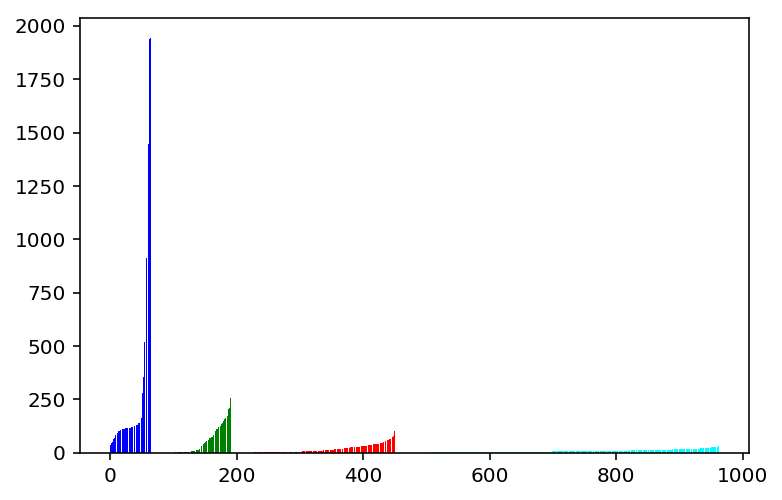

In [71]:
plotMEConvolution(MEConvMat[0], MEConvMat[1], MEConvMat[2], MEConvMat[3])

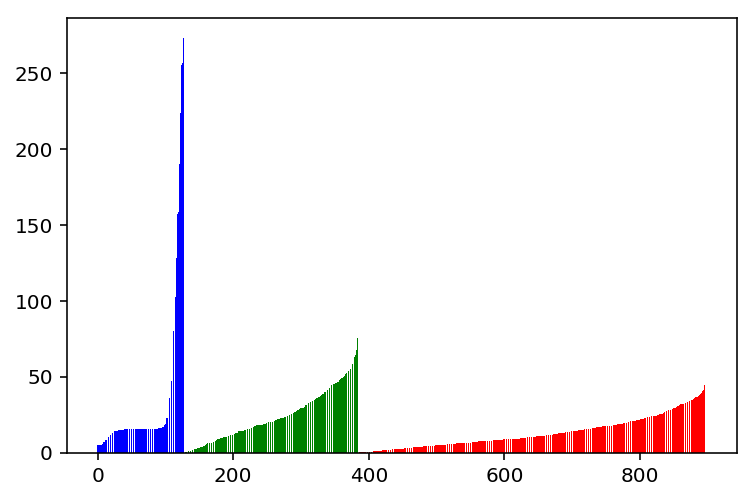

In [72]:
plotMEFullyConnected(MEFullyConnectedMat[0], MEFullyConnectedMat[1], MEFullyConnectedMat[2])

In [144]:
MEConvMat

[array([  39.87745978,   41.05929496,   47.09972842,   54.09540976,
          54.55193584,   59.23704031,   60.38432381,   75.66943035,
          78.93202736,   84.35422306,   88.11992073,   90.84255247,
          99.08520008,  100.29721928,  100.65193359,  102.21838169,
         102.46394382,  102.52054165,  103.01486553,  107.94485756,
         109.45715862,  110.62998016,  112.85551743,  113.57849907,
         113.60159599,  114.68394173,  116.88740021,  118.91652122,
         120.54511372,  121.35636578,  122.91910076,  124.0975742 ,
         124.36299236,  127.75766926,  127.79614479,  128.77632534,
         128.9447118 ,  129.55262356,  130.05897854,  130.37975227,
         130.68867878,  131.02654129,  131.99450302,  134.49408985,
         136.23587646,  136.47774109,  138.93218708,  145.27385036,
         155.18843224,  155.42936859,  163.42374237,  169.66479839,
         198.60292526,  239.72837204,  348.88932198,  352.73423157,
         543.4539946 ,  556.74415405,  797.67341

In [73]:
METotal = MEConv1
totes = 0
for hello in METotal:
    totes = totes + hello
print(totes)

18598.697329359053


In [ ]:
""""
conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
   # conv1_bn = tf.nn.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_pool, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
   # conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_pool, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
   # conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_pool, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    #conv4_bn = tf.nn.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_pool)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    #full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    #full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    #full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    #full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)"""